In [26]:
import torch
import yaml

In [27]:
# load yaml 
with open('conf/config_partoken_resume.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

model_cfg = cfg['model']
train_cfg = cfg['train']
multistage_cfg = cfg['multistage']


In [28]:
# load ec dataset (test set)
from utils.proteinshake_dataset import get_dataset, create_dataloader

train_dataset, val_dataset, test_dataset, num_classes = get_dataset(
    dataset_name='enzymecommission',
    split='structure',
    test_mode=False,
)


Number of proteins: 15603
JSON files for all splits already exist. Loading from files...
Loaded 11477 train, 1495 val, 1556 test structures
Found 7 unique labels in processed data
Train dataset size: 11477
Validation dataset size: 1495
Test dataset size: 1556


In [29]:
test_loader = create_dataloader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=8,
)

In [30]:
test_loader

In [31]:
import torch
from partoken_resume_lightning import ParTokenResumeTrainingLightning

# Load trained model
checkpoint_path = "./outputs/codebook-resume/enzymecommission/structure/2025-09-19-12-42-17/best-partoken-epoch=00-val_acc=0.567.ckpt"
model = ParTokenResumeTrainingLightning.load_from_checkpoint(
    checkpoint_path,
    # model_cfg=model_cfg,  # Your model config
    # train_cfg=train_cfg,  # Your train config  
    # multistage_cfg=multistage_cfg,  # Your multistage config
    # num_classes=num_classes
)

# Extract codebook information
codebook_embeddings = model.model.codebook.embeddings  # [codebook_size, embedding_dim]
usage_stats = model.model.codebook.ema_counts           # [codebook_size] 
codebook_size = model.model.codebook.K                  # Number of codes
embedding_dim = model.model.codebook.D                  # Embedding dimension

print(f"Codebook size: {codebook_size}")
print(f"Embedding dimension: {embedding_dim}")
print(f"Codebook embeddings shape: {codebook_embeddings.shape}")
print(f"Usage statistics shape: {usage_stats.shape}")


SETTING UP JOINT TRAINING (BACKBONE + CODEBOOK)
✓ Loss weights: λ_vq=1.0e+00, λ_ent=1.0e-01, λ_psc=1.0e-02
✓ Training mode: Joint training (backbone + EMA codebook)
✓ Trainable parameters: 711,515
✓ Model training mode: True

Codebook size: 256
Embedding dimension: 100
Codebook embeddings shape: torch.Size([256, 100])
Usage statistics shape: torch.Size([256])


/home/wangx86/miniconda3/envs/partoken/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


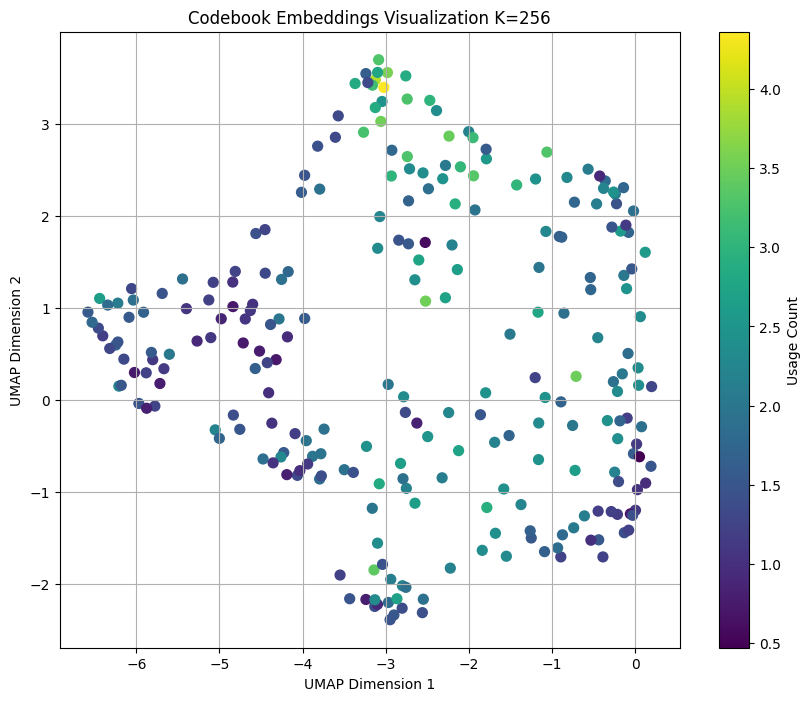

In [32]:
# plot the codebook embedding using umap
import umap
import matplotlib.pyplot as plt
import numpy as np

reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(codebook_embeddings.cpu().numpy())

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=usage_stats.cpu().numpy(), cmap='viridis', s=50)
plt.colorbar(label='Usage Count')
plt.title(f'Codebook Embeddings Visualization K={codebook_size}')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()


In [33]:
sum(usage_stats).item()

479.8995361328125

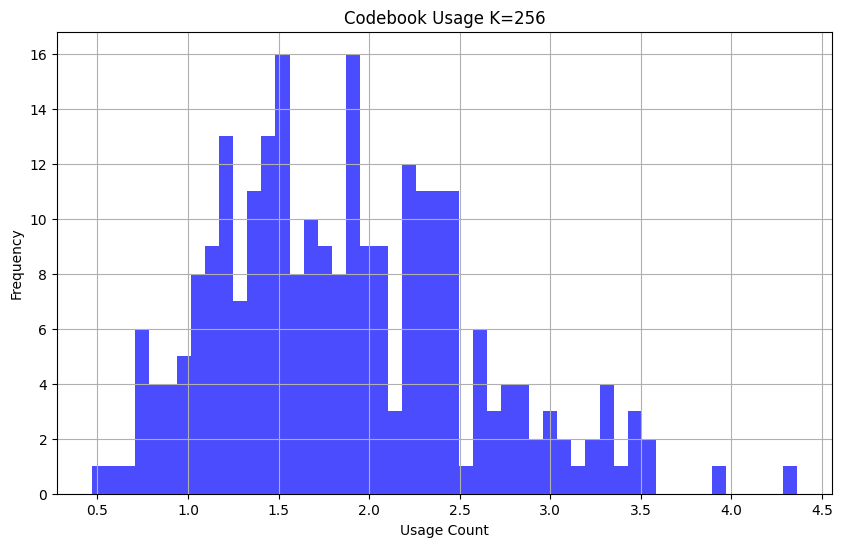

In [34]:
# plot histogram of usage stats
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(usage_stats.cpu().numpy(), bins=50, color='blue', alpha=0.7)
plt.title(f'Codebook Usage K={codebook_size}')
plt.xlabel('Usage Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [35]:
import torch

model.eval()
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

all_embeddings = []
all_assignments = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch to device
        for attr in ['node_s', 'node_v', 'edge_s', 'edge_v', 'edge_index', 'batch', 'y']:
            if hasattr(batch, attr):
                setattr(batch, attr, getattr(batch, attr).to(model.device))
        if hasattr(batch, 'seq'):
            batch.seq = batch.seq.to(model.device)

        # Forward pass through the model
        h_V = (batch.node_s, batch.node_v)
        h_E = (batch.edge_s, batch.edge_v)
        seq = batch.seq if hasattr(batch, 'seq') and hasattr(model.model, 'sequence_embedding') else None

        # Get cluster embeddings and codebook assignments by calling model.model directly
        # Process through GVP layers to get node features
        h_V_encoded = model.model.node_encoder(h_V)
        h_E_encoded = model.model.edge_encoder(h_E)
        
        for layer in model.model.gvp_layers:
            h_V_encoded = layer(h_V_encoded, batch.edge_index, h_E_encoded)
            
        node_features = model.model.output_projection(h_V_encoded)
        
        # Convert to dense format for partitioning
        from torch_geometric.utils import to_dense_batch
        dense_x, mask = to_dense_batch(node_features, batch.batch)
        dense_index, _ = to_dense_batch(
            torch.arange(node_features.size(0), device=node_features.device), batch.batch
        )
        
        # Apply partitioner to get cluster features
        cluster_features, assignment_matrix = model.model.partitioner(
            dense_x, None, mask, edge_index=batch.edge_index, batch_vec=batch.batch, dense_index=dense_index
        )
        
        # Get valid cluster mask
        cluster_valid_mask = (assignment_matrix.sum(dim=1) > 0)
        
        # Get codebook assignments
        _, code_indices, _, _ = model.model.codebook(cluster_features, mask=cluster_valid_mask)

        # Store results - only keep valid clusters
        for b in range(cluster_features.shape[0]):
            valid_mask_b = cluster_valid_mask[b]
            if valid_mask_b.any():
                valid_embeddings = cluster_features[b][valid_mask_b]  # [num_valid_clusters, D]
                valid_indices = code_indices[b][valid_mask_b]         # [num_valid_clusters]
                
                all_embeddings.append(valid_embeddings.cpu())
                all_assignments.append(valid_indices.cpu())

# Concatenate results
all_embeddings = torch.cat(all_embeddings, dim=0)  # [total_valid_clusters, D]
all_assignments = torch.cat(all_assignments, dim=0)  # [total_valid_clusters]

print("Cluster embeddings shape:", all_embeddings.shape)
print("Code assignments shape:", all_assignments.shape)
print("Number of unique codes used:", len(torch.unique(all_assignments[all_assignments >= 0])))

Cluster embeddings shape: torch.Size([7763, 100])
Code assignments shape: torch.Size([7763])
Number of unique codes used: 253


In [36]:
print(all_assignments[:5])

tensor([189,  49, 244,  60, 222])


Original cluster embeddings: 7763
After outlier removal: 7685
Removed 78 outliers (1.0%)


/home/wangx86/miniconda3/envs/partoken/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


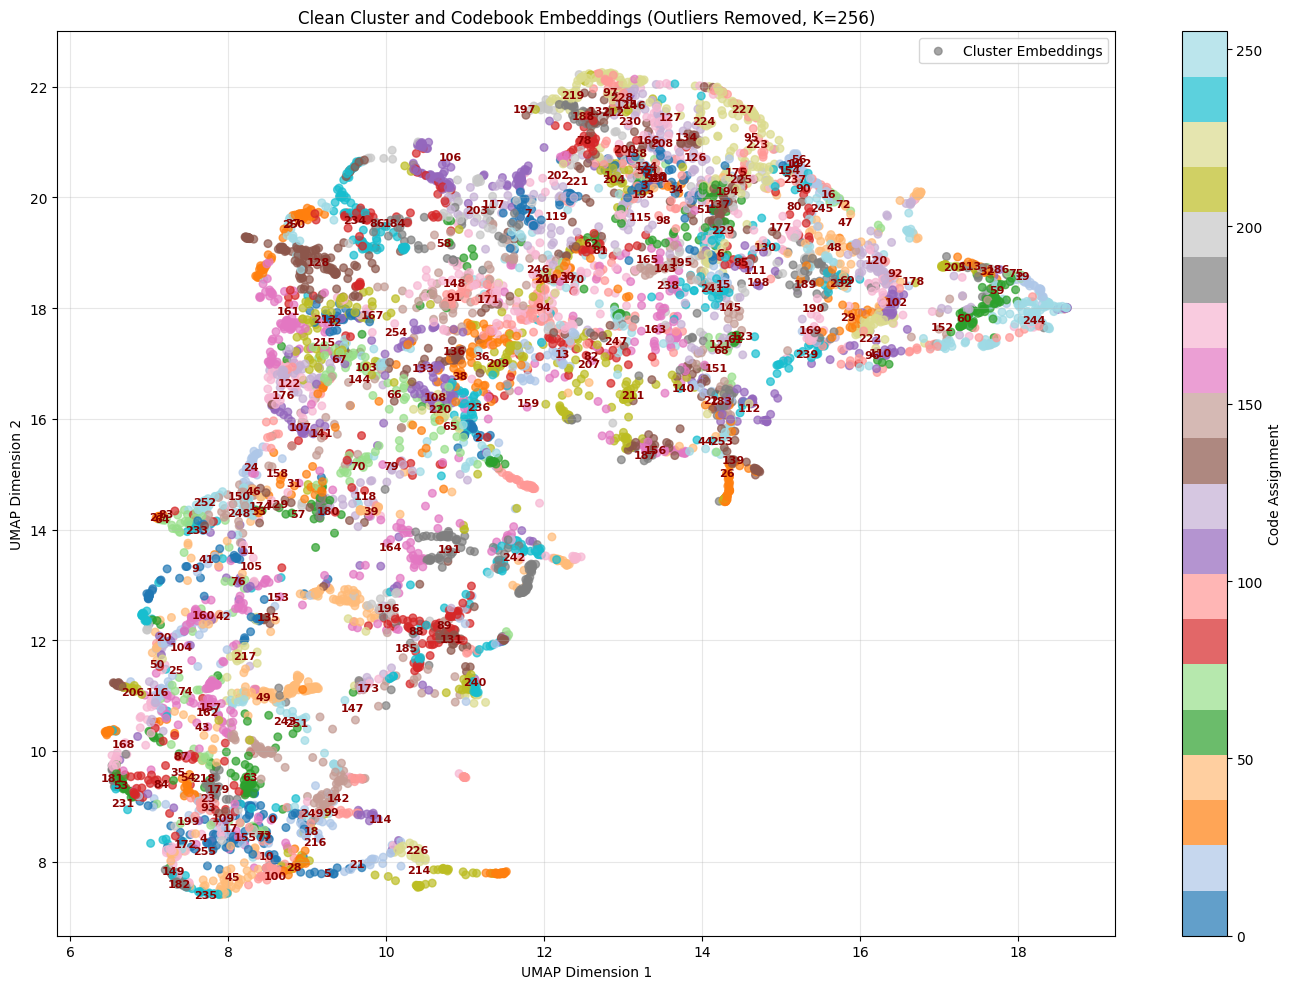

Valid inlier embeddings (with assignments): 7685
Unique codes used by inliers: 251
Codebook embeddings: 256


In [45]:
# Remove outliers and plot cleaner UMAP visualization
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Detect outliers in cluster embeddings using Isolation Forest
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(all_embeddings.numpy())

# Use Isolation Forest to detect outliers
# Reduce contamination from 0.1 (10%) to 0.05 (5%) to remove fewer outliers
isolation_forest = IsolationForest(contamination=0.01, random_state=42)  # Remove top 5% outliers
outlier_labels = isolation_forest.fit_predict(scaled_embeddings)

# Keep only inliers (outlier_labels == 1)
inlier_mask = outlier_labels == 1
inlier_embeddings = all_embeddings[inlier_mask]
inlier_assignments = all_assignments[inlier_mask]

print(f"Original cluster embeddings: {len(all_embeddings)}")
print(f"After outlier removal: {len(inlier_embeddings)}")
print(f"Removed {len(all_embeddings) - len(inlier_embeddings)} outliers ({100 * (1 - len(inlier_embeddings)/len(all_embeddings)):.1f}%)")

# Combine inlier cluster embeddings and codebook embeddings for joint UMAP
combined_embeddings_clean = torch.cat([inlier_embeddings, codebook_embeddings.cpu()], dim=0)

# Fit UMAP on clean combined data
reducer_clean = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)
combined_2d_clean = reducer_clean.fit_transform(combined_embeddings_clean.numpy())

# Split back into cluster and codebook embeddings
n_inliers = inlier_embeddings.shape[0]
cluster_2d_clean = combined_2d_clean[:n_inliers]
codebook_2d_clean = combined_2d_clean[n_inliers:]

plt.figure(figsize=(14, 10))

# Plot inlier cluster embeddings (colored by their codebook assignments)
valid_inlier_assignments = inlier_assignments[inlier_assignments >= 0]
valid_cluster_2d_clean = cluster_2d_clean[inlier_assignments >= 0]

scatter = plt.scatter(valid_cluster_2d_clean[:, 0], valid_cluster_2d_clean[:, 1], 
                     c=valid_inlier_assignments.numpy(), cmap='tab20', s=30, alpha=0.7, 
                     label='Cluster Embeddings')

# Add integer labels for codebook embeddings (no markers)
for i, (x, y) in enumerate(codebook_2d_clean):
    plt.annotate(str(i), (x, y), xytext=(0, 0), textcoords='offset points', 
                fontsize=8, color='darkred', fontweight='bold', ha='center', va='center')

plt.colorbar(scatter, label='Code Assignment')
plt.title(f'Clean Cluster and Codebook Embeddings (Outliers Removed, K={codebook_size})')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Valid inlier embeddings (with assignments): {len(valid_inlier_assignments)}")
print(f"Unique codes used by inliers: {len(torch.unique(valid_inlier_assignments))}")
print(f"Codebook embeddings: {codebook_size}")


Number of proteins: 1556
Embedding dimension: 100
Number of unique protein labels: 7
Number of unique codebook assignments: 206


/home/wangx86/miniconda3/envs/partoken/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


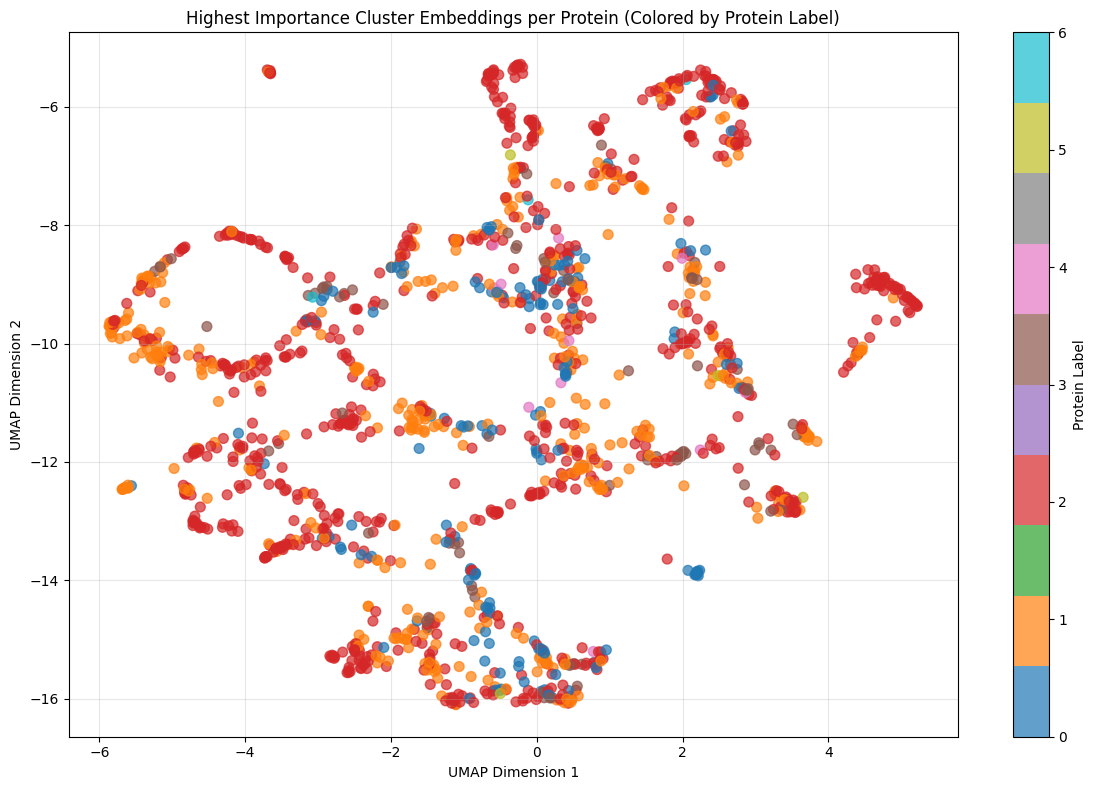

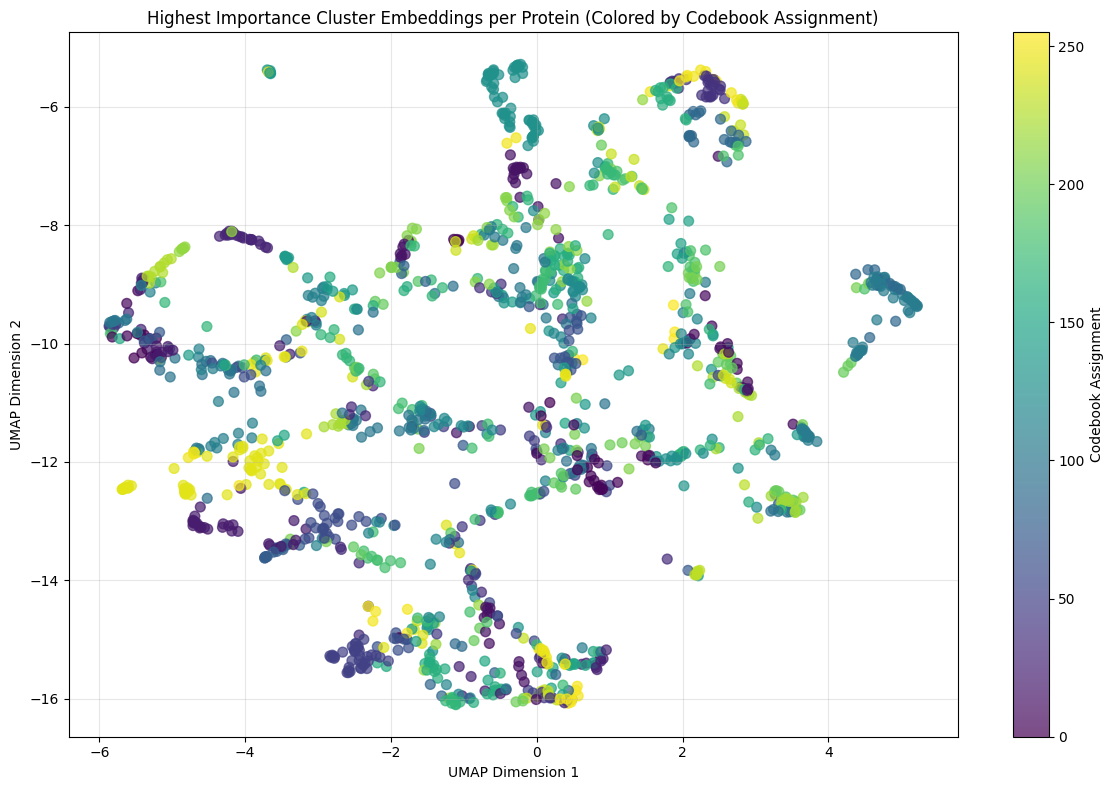

Label distribution: [153 430 856  98  12   4   3]
Codebook assignment distribution (top 10): [10  3  5 17  2  2  3  9  4  1]


In [ ]:
# Extract highest importance cluster embedding per protein and plot by protein label
import torch
import matplotlib.pyplot as plt
import numpy as np
import umap

model.eval()
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

protein_embeddings = []
protein_labels = []
protein_codebook_assignments = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch to device
        for attr in ['node_s', 'node_v', 'edge_s', 'edge_v', 'edge_index', 'batch', 'y']:
            if hasattr(batch, attr):
                setattr(batch, attr, getattr(batch, attr).to(model.device))
        if hasattr(batch, 'seq'):
            batch.seq = batch.seq.to(model.device)

        # Forward pass through the model
        h_V = (batch.node_s, batch.node_v)
        h_E = (batch.edge_s, batch.edge_v)
        seq = batch.seq if hasattr(batch, 'seq') and hasattr(model.model, 'sequence_embedding') else None

        # Get cluster embeddings, assignments, and importance scores
        # Process through GVP layers to get node features
        h_V_encoded = model.model.node_encoder(h_V)
        h_E_encoded = model.model.edge_encoder(h_E)
        
        for layer in model.model.gvp_layers:
            h_V_encoded = layer(h_V_encoded, batch.edge_index, h_E_encoded)
            
        node_features = model.model.output_projection(h_V_encoded)
        
        # Convert to dense format for partitioning
        from torch_geometric.utils import to_dense_batch
        dense_x, mask = to_dense_batch(node_features, batch.batch)
        dense_index, _ = to_dense_batch(
            torch.arange(node_features.size(0), device=node_features.device), batch.batch
        )
        
        # Apply partitioner to get cluster features
        cluster_features, assignment_matrix = model.model.partitioner(
            dense_x, None, mask, edge_index=batch.edge_index, batch_vec=batch.batch, dense_index=dense_index
        )
        
        # Get valid cluster mask
        cluster_valid_mask = (assignment_matrix.sum(dim=1) > 0)
        
        # Get codebook assignments
        _, code_indices, _, _ = model.model.codebook(cluster_features, mask=cluster_valid_mask)
        
        # Global residue pooling for attention query
        residue_pooled = model.model._pool_nodes(node_features, batch.batch)  # [B, ns]
        
        # Global-to-cluster attention to get importance scores
        c_star, cluster_importance, _ = model.model.global_cluster_attn(
            residue_pooled, cluster_features, cluster_valid_mask
        )  # cluster_importance: [B, S]

        # For each protein in the batch, find the cluster with highest importance
        for b in range(cluster_features.shape[0]):
            valid_mask_b = cluster_valid_mask[b]
            if valid_mask_b.any():
                # Get importance scores for valid clusters
                valid_importance = cluster_importance[b][valid_mask_b]  # [num_valid_clusters]
                valid_cluster_features = cluster_features[b][valid_mask_b]  # [num_valid_clusters, D]
                valid_code_indices = code_indices[b][valid_mask_b]  # [num_valid_clusters]
                
                # Find cluster with highest importance
                max_importance_idx = torch.argmax(valid_importance)
                highest_importance_embedding = valid_cluster_features[max_importance_idx]  # [D]
                highest_importance_code = valid_code_indices[max_importance_idx]  # scalar
                
                # Store results
                protein_embeddings.append(highest_importance_embedding.cpu())
                protein_labels.append(batch.y[b].cpu().item())
                protein_codebook_assignments.append(highest_importance_code.cpu().item())

# Convert to tensors
protein_embeddings = torch.stack(protein_embeddings)  # [num_proteins, D]
protein_labels = np.array(protein_labels)  # [num_proteins]
protein_codebook_assignments = np.array(protein_codebook_assignments)  # [num_proteins]

print(f"Number of proteins: {len(protein_embeddings)}")
print(f"Embedding dimension: {protein_embeddings.shape[1]}")
print(f"Number of unique protein labels: {len(np.unique(protein_labels))}")
print(f"Number of unique codebook assignments: {len(np.unique(protein_codebook_assignments))}")

# Apply UMAP to protein embeddings
reducer_protein = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
protein_2d = reducer_protein.fit_transform(protein_embeddings.numpy())

# Create figure with protein embeddings colored by protein labels
plt.figure(figsize=(12, 8))

# Plot protein embeddings colored by their true labels
# Use Set1 colormap which provides better distinction for 7 categories
scatter = plt.scatter(protein_2d[:, 0], protein_2d[:, 1], 
                     c=protein_labels, cmap='Set1', s=50, alpha=0.7)

plt.colorbar(scatter, label='Protein Label')
plt.title(f'Highest Importance Cluster Embeddings per Protein (Colored by Protein Label)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Also create a figure colored by codebook assignments
plt.figure(figsize=(12, 8))

scatter2 = plt.scatter(protein_2d[:, 0], protein_2d[:, 1], 
                      c=protein_codebook_assignments, cmap='viridis', s=50, alpha=0.7)

plt.colorbar(scatter2, label='Codebook Assignment')
plt.title(f'Highest Importance Cluster Embeddings per Protein (Colored by Codebook Assignment)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Label distribution: {np.bincount(protein_labels)}")
print(f"Codebook assignment distribution (top 10): {np.bincount(protein_codebook_assignments)[:10]}")